## Оглавление
* [1. Загрузка данных](#load)
* [2. EDA](#eda)
    * [2.1 Распределение целевой переменной](#target)
    * [2.2 Анализ признаков](#features)
        * [2.2.1 Количественные признаки](#num_features)
        * [2.2.2 Категориальные признаки](#cat_features)
        * [2.2.3 Бинарные признаки](#binary_features)
        * [2.2.4 Матрица корреляций](#corr)
* [3. Проверка данных](#data_check)
    * [3.1 Обработка пропусков](#nan)
    * [3.2 Обработка выбросов](#outlier)
* [4. Разбиение на test и train](#split)
* [5. Построение модели](#modeling)
* [6. Прогнозирование на тестовом датасете](#prediction)

In [102]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [103]:
import warnings
warnings.filterwarnings('ignore')

In [104]:
matplotlib.rcParams.update({'font.size': 14})
#plt.style.use('dark_background')
%config InlineBackend.figure_format = 'svg'

## 1. Загрузка данных <a class='anchor' id='load'>

In [105]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'

In [106]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

### Описание файлов
* **train.csv** - the training set
* **test.csv** - the test set
* **sampleSubmission.csv** - a sample submission file in the correct format

### Описание параметров, использующихся в данных
* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [107]:
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855
9999,7202,94,1.0,35.815476,22.301367,6.0,9,9.0,1975,0.127376,B,B,43,8429,3,NaN,3,9,B,177685.627486


### Приведение типов

In [108]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [109]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

In [110]:
train_df.dtypes

Id                object
DistrictId        object
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

## 2. EDA <a class='anchor' id='eda'>

### 2.1 Распределение целевой переменной <a class='anchor' id='target'>

In [111]:
target_mean = round(train_df['Price'].mean(), 2)
target_median = train_df['Price'].median()
target_bins = train_df['Price'] // 10000 * 10000
target_mode = target_bins.mode()[0]

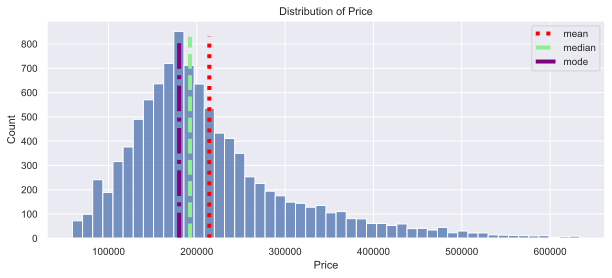

In [112]:
plt.figure(figsize = (10, 4))

ax = sns.histplot(data=train_df, x='Price', bins=50, ec='w')

y = np.linspace(0, 830, 10)
plt.plot([target_mean] * 10, y, label='mean', linestyle=':', linewidth=4, c='red')
plt.plot([target_median] * 10, y, label='median', linestyle='--', linewidth=4, c='lightgreen')
plt.plot([target_mode] * 10, y, label='mode', linestyle='-.', linewidth=4, c='purple')

plt.title('Distribution of Price')
plt.legend()
plt.show()

### 2.2 Анализ признаков <a class='anchor' id='features'>

#### 2.2.1 Количественные признаки<a class='anchor' id='num_features'>

In [113]:
num_features = train_df.select_dtypes(include=['float64', 'float32', 'float16'])
num_features.drop('Price', axis=1, inplace=True)

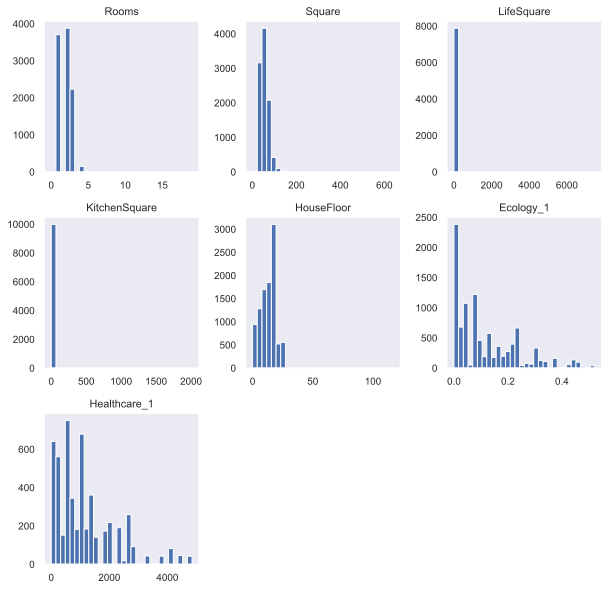

In [114]:
num_features.hist(figsize=(10,10), bins=30, grid=False);

#### 2.2.2 Категориальные признаки<a class='anchor' id='cat_features'>

In [115]:
train_df.select_dtypes(include='object').columns.tolist()

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

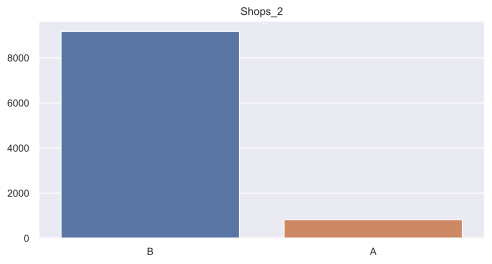

In [116]:
counts = train_df['Shops_2'].value_counts()
    
plt.figure(figsize=(8,4))    
plt.title('Shops_2')
sns.barplot(counts.index, counts.values)
    
plt.show()

#### 2.2.3 Бинарные признаки<a class='anchor' id='binary_features'>

In [117]:
bin_features = train_df.select_dtypes(include='int64')
bin_features

,Floor,HouseYear,Social_1,Social_2,Social_3,Helthcare_2,Shops_1
0,4,2014,11,3097,0,0,0
1,7,1966,30,6207,1,1,0
2,2,1988,33,5261,0,3,1
3,10,1977,1,264,0,0,1
4,16,1972,33,8667,2,0,6
...,...,...,...,...,...,...,...
9995,3,1981,52,10311,6,1,9
9996,13,1977,2,629,1,0,0
9997,3,1958,20,4386,14,1,5
9998,3,1969,47,8004,3,3,5


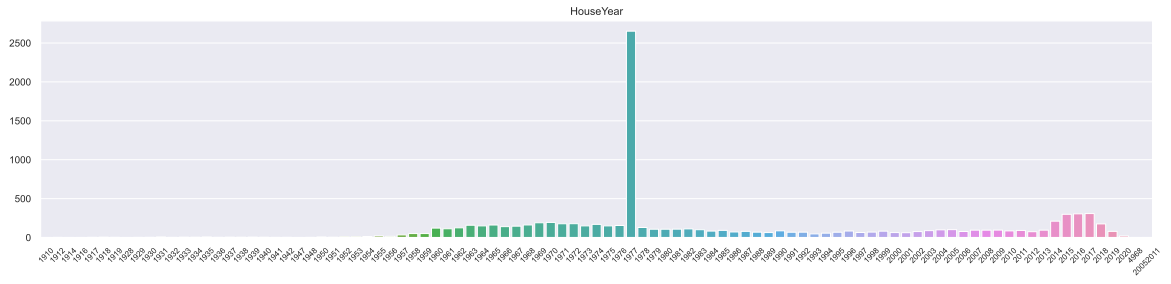

In [118]:
counts = train_df['HouseYear'].value_counts()
    
plt.figure(figsize=(20,4))    
plt.title('HouseYear')
bar_plot = sns.barplot(counts.index, counts.values)

bar_plot.set_xticklabels(bar_plot.get_xticklabels(), rotation=45, fontsize=8)
    
plt.show()

#### 2.2.4 Матрица корреляций<a class='anchor' id='corr'>

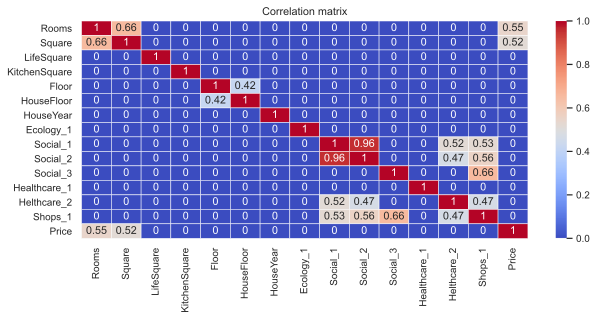

In [119]:
plt.figure(figsize = (10, 4))

sns.set(font_scale=0.9)

corr_matrix = train_df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

### 3. Проверка данных<a class='anchor' id='data_check'>

#### 3.1 Обработка пропусков<a class='anchor' id='nan'>

In [120]:
train_df.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

#### 3.2 Обработка выбросов<a class='anchor' id='outlier'>

In [121]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.kitchen_square_quantile = None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        self.kitchen_square_quantile = X['KitchenSquare'].quantile(.975)
    
    def transform(self, X):
        """Трансформация данных"""

        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms']
        
        # KitchenSquare
        condition = (X['KitchenSquare'].isna()) \
                    | (X['KitchenSquare'] > self.kitchen_square_quantile)
        
        X.loc[condition, 'KitchenSquare'] = self.medians['KitchenSquare']

        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        
        floor_outliers = X.loc[X['Floor'] > X['HouseFloor']].index
        X.loc[floor_outliers, 'Floor'] = X.loc[floor_outliers, 'HouseFloor']\
                                            .apply(lambda x: random.randint(1, x))
        
        # HouseYear
        current_year = datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
            
        # LifeSquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        condition = (X['LifeSquare'].isna()) & \
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())
        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 3
        
        
        X.fillna(self.medians, inplace=True)
        
        return X

In [122]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.house_year_max = None
        self.floor_max = None
        self.district_size = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
                
        # Target encoding
        ## District, Rooms
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            self.med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceByDistrict'})
            
            self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()
            
        ## floor, year
        if y is not None:
            self.floor_max = df['Floor'].max()
            self.house_year_max = df['HouseYear'].max()
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()
        

        
    def transform(self, X):
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        
        X['DistrictSize'].fillna(5, inplace=True)
        
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
            X['MedPriceByDistrict'].fillna(self.med_price_by_district_median, inplace=True)
            
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            X['MedPriceByFloorYear'].fillna(self.med_price_by_floor_year_median, inplace=True)
        
        return X
    
    def floor_to_cat(self, X):
        bins = [0, 3, 5, 9, 15, self.floor_max]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)

        X['floor_cat'].fillna(-1, inplace=True) 
        return X
     
    def year_to_cat(self, X):
        bins = [0, 1941, 1945, 1980, 2000, 2010, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

        X['year_cat'].fillna(-1, inplace=True)
        return X
            
    

### 4. Разбиение на test и train  <a class='anchor' id='split'>

In [123]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price']

In [124]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Helthcare_2', 'Shops_1', 'Shops_2']

new_feature_names = ['Rooms_outlier', 'HouseFloor_outlier', 'HouseYear_outlier', 'LifeSquare_nan', 'DistrictSize',
                     'new_district', 'IsDistrictLarge',  'MedPriceByDistrict', 'MedPriceByFloorYear']

target_name = 'Price'

In [125]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [126]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)

In [127]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 22), (3300, 22), (5000, 22))

In [128]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

In [129]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

### 5. Построение модели  <a class='anchor' id='modeling'>

In [130]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, VotingRegressor

**Обучение**

In [131]:
gb = GradientBoostingRegressor(random_state=42)
rf = RandomForestRegressor(random_state=42)

In [132]:
gb.fit(X_train, y_train)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [133]:
vr = VotingRegressor(estimators=[('gb', gb), ('rf', rf)])
vr.fit(X_train, y_train)

VotingRegressor(estimators=[('gb', GradientBoostingRegressor(random_state=42)),
                            ('rf', RandomForestRegressor(random_state=42))])

**Оценка модели**

In [134]:
y_train_pred_gb = reg1.predict(X_train)
y_train_pred_rf = reg2.predict(X_train)
y_train_pred_vr = ereg.predict(X_train)

In [135]:
print(f'GradientBoostingRegressor r2: {r2(y_train, y_pred_train1)}')
print(f'RandomForestRegressor r2: {r2(y_train, y_pred_train2)}')
print(f'VotingRegressor r2: {r2(y_train, y_pred_train3)}')

GradientBoostingRegressor r2: 0.8026232929061677
RandomForestRegressor r2: 0.9665874496784272
VotingRegressor r2: 0.9059739127771917


In [136]:
y_test_pred_gb = reg1.predict(X_valid)
y_test_pred_rf = reg2.predict(X_valid)
y_test_pred_vr = ereg.predict(X_valid)

In [137]:
print(f'GradientBoostingRegressor r2: {r2(y_valid, y_pred1)}')
print(f'RandomForestRegressor r2: {r2(y_valid, y_pred2)}')
print(f'VotingRegressor r2: {r2(y_valid, y_pred3)}')

GradientBoostingRegressor r2: 0.6586021607155886
RandomForestRegressor r2: 0.6681263752827696
VotingRegressor r2: 0.6723083261834052


In [138]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(12,6))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

Train R2:	0.902
Test R2:	0.671


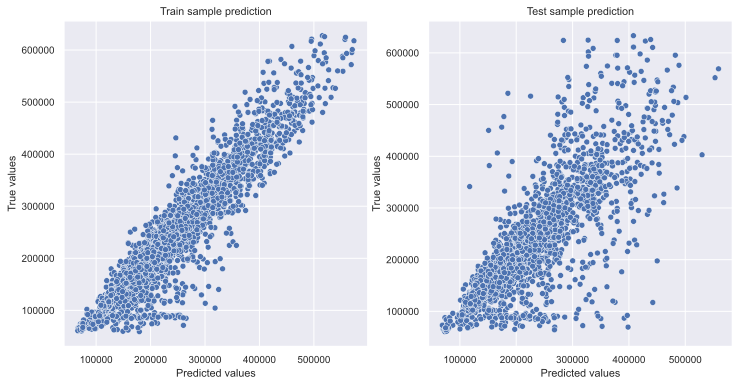

In [139]:
evaluate_preds(y_train, y_train_pred_vr, y_valid, y_test_pred_vr)

### 6. Прогнозирование на тестовом датасете  <a class='anchor' id='prediction'>

In [140]:
submit = pd.read_csv('sample_submission.csv')

In [141]:
predictions = vr.predict(test_df)

In [142]:
submit['Price'] = predictions
submit.to_csv('vr_submit.csv', index=False)